=== ЗАПУСК ЛОГИСТИЧЕСКОЙ ЗАДАЧИ ===
Расход (Базовый):   33200
Расход (Симплекс): 29600
ВЫГОДА: 3600 (10.8%)


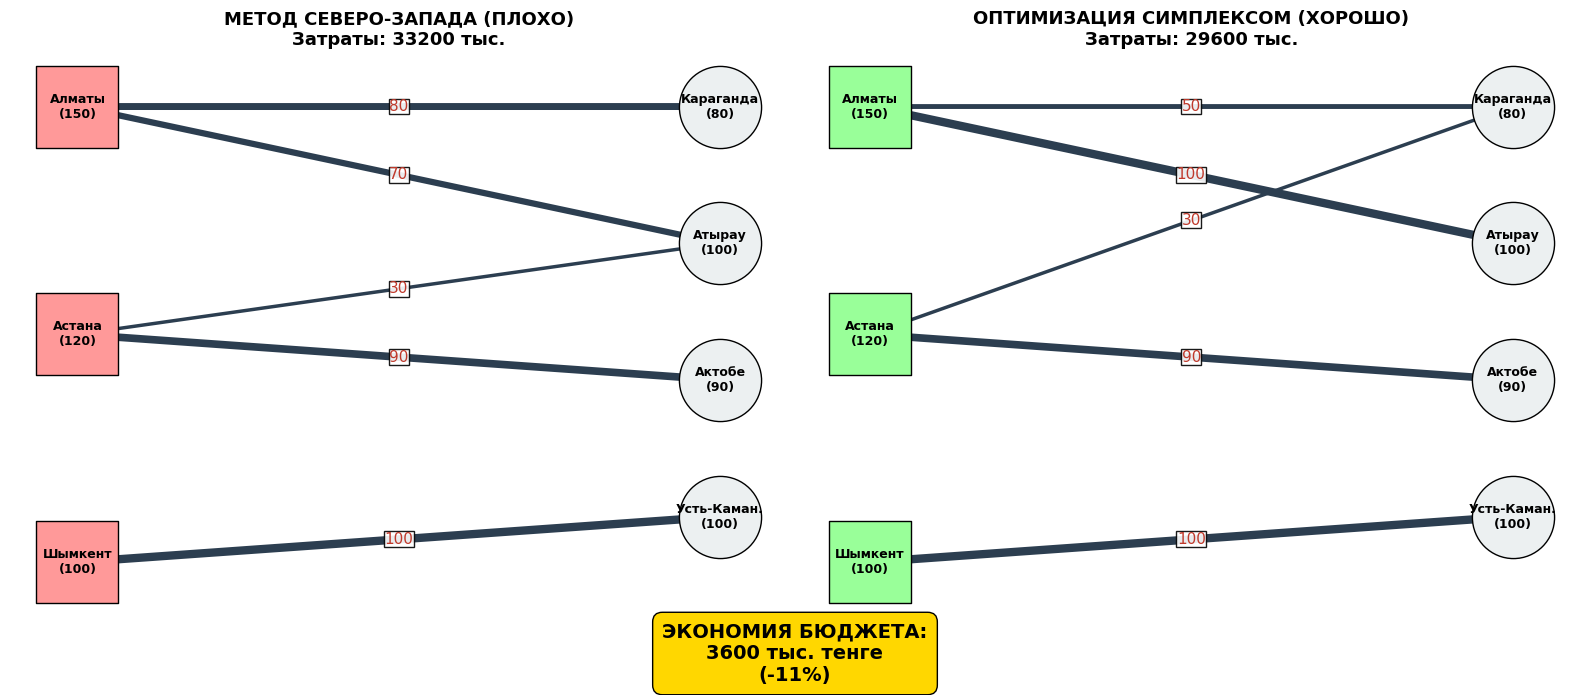

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# ==========================================
# 1. АЛГОРИТМЫ (Оставляем как есть)
# ==========================================

def northwest_corner_method(supply, demand):
    s = supply.copy()
    d = demand.copy()
    rows = len(s)
    cols = len(d)
    allocation = np.zeros((rows, cols))

    i = 0
    j = 0
    while i < rows and j < cols:
        qty = min(s[i], d[j])
        allocation[i][j] = qty
        s[i] -= qty
        d[j] -= qty

        if s[i] == 0 and d[j] == 0:
            i += 1
            j += 1
        elif s[i] == 0:
            i += 1
        else:
            j += 1
    return allocation

def get_potentials(alloc, costs):
    rows, cols = alloc.shape
    u = [None] * rows; v = [None] * cols; u[0] = 0
    for _ in range(rows*cols):
        changed = False
        for i in range(rows):
            for j in range(cols):
                if alloc[i][j] > 1e-5:
                    if u[i] is not None and v[j] is None:
                        v[j] = costs[i][j] - u[i]; changed = True
                    elif u[i] is None and v[j] is not None:
                        u[i] = costs[i][j] - v[j]; changed = True
        if not changed: break
    return [x if x is not None else 0 for x in u], [x if x is not None else 0 for x in v]

def get_path_fixed(start, alloc):
    rows, cols = alloc.shape
    stack = [(start, [start], 1)]
    while stack:
        curr, path, prev_type = stack.pop()
        r, c = curr
        if curr == start and len(path) > 3: return path
        if prev_type == 1:
            for j in range(cols):
                if j != c:
                    if alloc[r][j] > 1e-5 or (r, j) == start:
                        if (r, j) not in path or (r, j) == start:
                            stack.append(((r, j), path + [(r, j)], 0))
        else:
            for i in range(rows):
                if i != r:
                    if alloc[i][c] > 1e-5 or (i, c) == start:
                        if (i, c) not in path or (i, c) == start:
                            stack.append(((i, c), path + [(i, c)], 1))
    return None

def fix_degeneracy(alloc, rows, cols):
    required = rows + cols - 1
    current = np.count_nonzero(alloc > 1e-5)
    if current < required:
        epsilon = 1e-6; cnt = current
        for i in range(rows):
            for j in range(cols):
                if alloc[i][j] < 1e-5 and cnt < required:
                    alloc[i][j] = epsilon; cnt += 1
    return alloc

def optimize_simplex(allocation, costs):
    alloc = allocation.copy()
    costs = np.array(costs); rows, cols = alloc.shape
    alloc = fix_degeneracy(alloc, rows, cols)

    for iteration in range(100):
        u, v = get_potentials(alloc, costs)
        min_delta = 0; entering = None

        for i in range(rows):
            for j in range(cols):
                if alloc[i][j] < 1e-5:
                    delta = costs[i][j] - (u[i] + v[j])
                    if delta < min_delta - 1e-7:
                        min_delta = delta; entering = (i, j)

        if entering is None: break
        path = get_path_fixed(entering, alloc)
        if not path: break

        cycle = path[:-1]
        minus_vals = [alloc[r][c] for k, (r, c) in enumerate(cycle) if k % 2 != 0]
        theta = min(minus_vals)

        for k, (r, c) in enumerate(cycle):
            if k % 2 == 0: alloc[r][c] += theta
            else:          alloc[r][c] -= theta

        alloc[alloc < 1e-9] = 0
        alloc = fix_degeneracy(alloc, rows, cols)

    alloc[alloc < 1e-3] = 0
    return alloc

# ==========================================
# 2. ВИЗУАЛИЗАЦИЯ
# ==========================================

def draw_kz_logistics(ax, allocation, title, supply, demand, names_s, names_d, theme_color):
    G = nx.DiGraph()
    rows, cols = allocation.shape

    left_labels = {f"S{i}": f"{names_s[i]}\n({int(supply[i])})" for i in range(rows)}
    right_labels = {f"D{j}": f"{names_d[j]}\n({int(demand[j])})" for j in range(cols)}

    left_nodes = list(left_labels.keys())
    right_nodes = list(right_labels.keys())

    pos = {}
    for i, n in enumerate(left_nodes): pos[n] = (0, -i * 10)
    for i, n in enumerate(right_nodes): pos[n] = (1, -i * 6)

    edge_labels = {}
    widths = []

    for i in range(rows):
        for j in range(cols):
            val = allocation[i][j]
            if val > 0:
                u, v = left_nodes[i], right_nodes[j]
                G.add_edge(u, v)
                edge_labels[(u, v)] = f"{int(val)}"
                widths.append(1 + (val / max(np.max(allocation), 1)) * 5)

    nx.draw_networkx_nodes(G, pos, nodelist=left_nodes, node_color=theme_color,
                           node_size=3500, node_shape='s', ax=ax, edgecolors='black')
    nx.draw_networkx_nodes(G, pos, nodelist=right_nodes, node_color='#ECF0F1',
                           node_size=3500, node_shape='o', ax=ax, edgecolors='black')

    nx.draw_networkx_labels(G, pos, labels={**left_labels, **right_labels},
                            font_size=9, font_weight="bold", ax=ax)

    nx.draw_networkx_edges(G, pos, width=widths, edge_color='#2C3E50',
                           arrowsize=25, arrowstyle='->', ax=ax)

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='#C0392B',
                                 font_size=11, ax=ax, rotate=False,
                                 bbox=dict(facecolor='white', edgecolor='black', alpha=0.9, pad=0.3))

    ax.set_title(title, fontsize=13, pad=10, fontweight='bold')
    ax.axis('off')

# ==========================================
# 3. ЛОВУШКА (ДАННЫЕ)
# ==========================================
def run_kazakhstan_scenario():
    # --- ДАННЫЕ ---
    names_supply = ["Алматы", "Астана", "Шымкент"]
    names_demand = ["Караганда", "Атырау", "Актобе", "Усть-Каман."]

    supply = [150, 120, 100]
    demand = [80, 100, 90, 100]

    # === ЛОВУШКА ЗДЕСЬ ===
    # Мы ставим ОГРОМНЫЕ цены в начале (слева-сверху),
    # и МАЛЕНЬКИЕ цены в конце (справа-сверху и слева-снизу).
    # Метод Северо-Запада попадется и выберет 150, 120, 100.
    # Симплекс найдет обходные пути по 10, 20, 30.

    costs = [
        #Кар  Атыр Акт  У-Ка
        [150, 120, 80,  10],  # Алматы: В Усть-Каман дешево, но "Север-запад" этого не увидит сразу
        [10,  100, 20,  90],  # Астана: В Караганду и Актобе дешево
        [90,  15,  100, 80]   # Шымкент: В Атырау супер дешево
    ]

    print("=== ЗАПУСК ЛОГИСТИЧЕСКОЙ ЗАДАЧИ ===")

    # 1. Глупый план
    plan_nw = northwest_corner_method(supply, demand)
    cost_nw = np.sum(plan_nw * costs)

    # 2. Умный план
    plan_simplex = optimize_simplex(plan_nw.copy(), costs)
    cost_simplex = np.sum(plan_simplex * costs)

    # Статистика
    savings = cost_nw - cost_simplex
    percent = (savings / cost_nw) * 100

    print(f"Расход (Базовый):   {int(cost_nw)}")
    print(f"Расход (Симплекс): {int(cost_simplex)}")
    print(f"ВЫГОДА: {savings:.0f} ({percent:.1f}%)")

    # --- ГРАФИКА ---
    fig = plt.figure(figsize=(16, 7))

    # Левый
    ax1 = fig.add_subplot(1, 2, 1)
    draw_kz_logistics(ax1, plan_nw,
                      f"МЕТОД СЕВЕРО-ЗАПАДА (ПЛОХО)\nЗатраты: {int(cost_nw)} тыс.",
                      supply, demand, names_supply, names_demand, "#FF9999") # Красный

    # Правый
    ax2 = fig.add_subplot(1, 2, 2)
    draw_kz_logistics(ax2, plan_simplex,
                      f"ОПТИМИЗАЦИЯ СИМПЛЕКСОМ (ХОРОШО)\nЗатраты: {int(cost_simplex)} тыс.",
                      supply, demand, names_supply, names_demand, "#99FF99") # Зеленый

    # Итог по центру
    result_text = f"ЭКОНОМИЯ БЮДЖЕТА:\n{int(savings)} тыс. тенге\n(-{percent:.0f}%)"
    plt.figtext(0.5, 0.02, result_text, ha="center", fontsize=14, fontweight='bold',
                bbox={"facecolor":"gold", "boxstyle":"round,pad=0.5"})

    plt.tight_layout(rect=[0, 0.1, 1, 1])
    plt.show()

if __name__ == "__main__":
    run_kazakhstan_scenario()

=== RESULTS ===
Northwest cost: 33200
Russell   cost: 8100
Simplex   cost: 8100
Savings vs NW: 25100 (75.6%)
Savings vs Russell: 0 (0.0%)


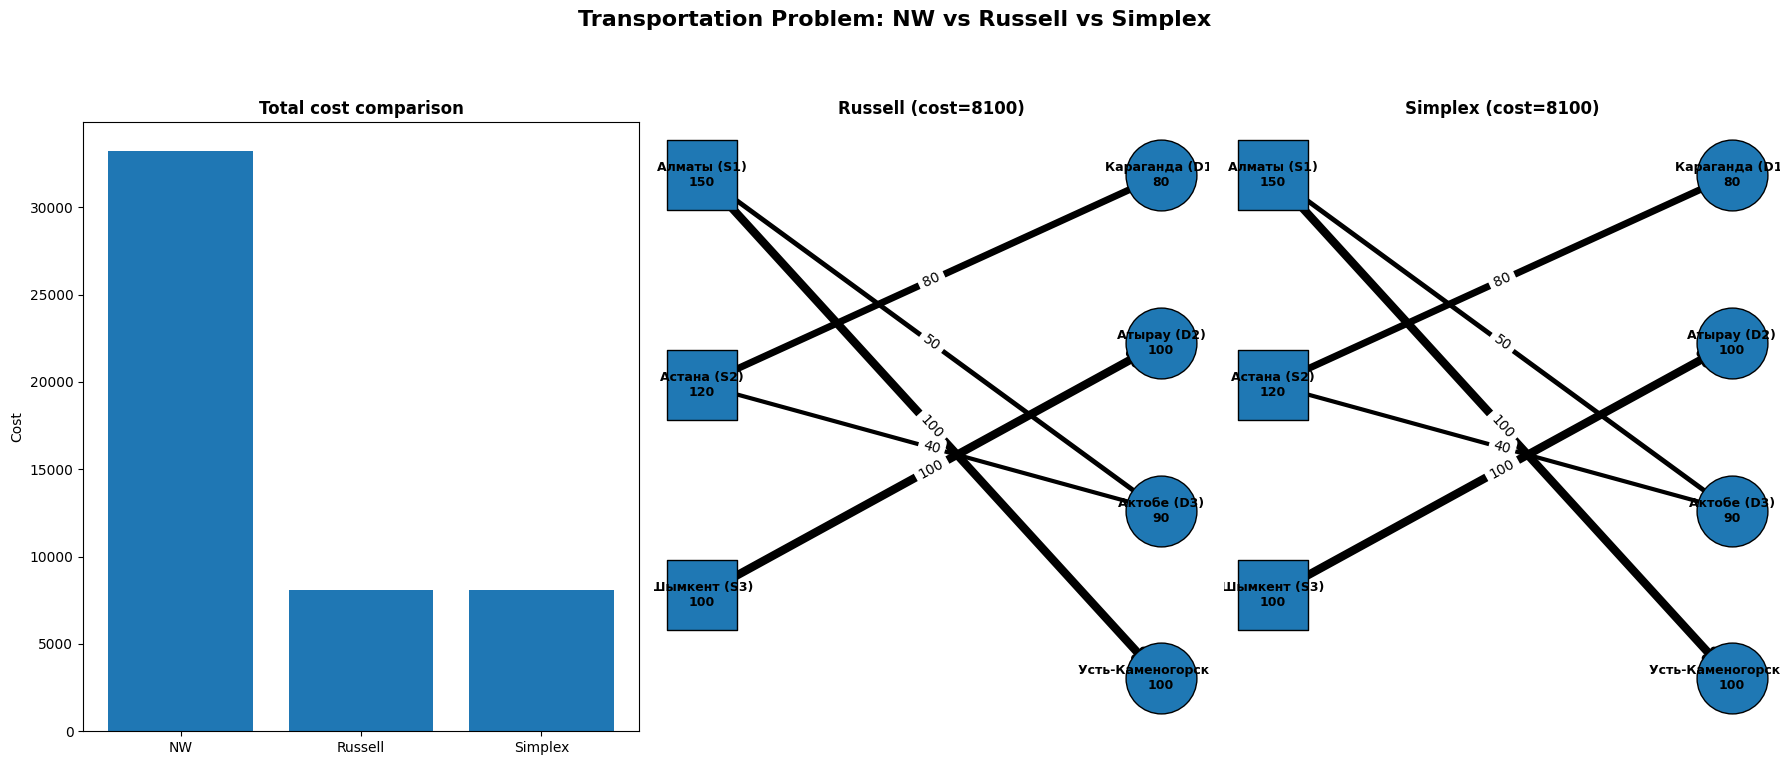

In [ ]:
# presentation_demo.py
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

EPS = 1e-6

# =========================
# 1) INITIAL METHODS
# =========================
def northwest_corner_method(supply, demand):
    s = supply.copy()
    d = demand.copy()
    rows, cols = len(s), len(d)
    alloc = np.zeros((rows, cols), dtype=float)
    i = j = 0
    while i < rows and j < cols:
        x = min(s[i], d[j])
        alloc[i, j] = x
        s[i] -= x
        d[j] -= x
        if abs(s[i]) < EPS and abs(d[j]) < EPS:
            i += 1
            j += 1
        elif abs(s[i]) < EPS:
            i += 1
        else:
            j += 1
    return alloc

def russell_approximation(supply, demand, costs):
    s = supply.copy()
    d = demand.copy()
    c = np.array(costs, dtype=float)
    rows, cols = c.shape
    alloc = np.zeros((rows, cols), dtype=float)

    for _ in range(10_000):
        if sum(s) <= EPS or sum(d) <= EPS:
            break

        u = [-1e18] * rows
        v = [-1e18] * cols

        for i in range(rows):
            if s[i] > EPS:
                valid = [c[i, j] for j in range(cols) if d[j] > EPS]
                u[i] = max(valid) if valid else -1e18

        for j in range(cols):
            if d[j] > EPS:
                valid = [c[i, j] for i in range(rows) if s[i] > EPS]
                v[j] = max(valid) if valid else -1e18

        best = None
        best_delta = 1e18
        for i in range(rows):
            if s[i] <= EPS:
                continue
            for j in range(cols):
                if d[j] <= EPS:
                    continue
                delta = c[i, j] - (u[i] + v[j])
                if delta < best_delta:
                    best_delta = delta
                    best = (i, j)

        if best is None:
            break

        i, j = best
        x = min(s[i], d[j])
        alloc[i, j] = x
        s[i] -= x
        d[j] -= x

    return alloc

# =========================
# 2) SIMPLEX (MODI)
# =========================
def fix_degeneracy(alloc, rows, cols):
    required = rows + cols - 1
    basic = np.count_nonzero(alloc > EPS)
    if basic >= required:
        return alloc
    need = required - basic
    for i in range(rows):
        for j in range(cols):
            if alloc[i, j] <= EPS:
                alloc[i, j] = EPS
                need -= 1
                if need == 0:
                    return alloc
    return alloc

def get_potentials(alloc, costs):
    rows, cols = alloc.shape
    u = [None] * rows
    v = [None] * cols
    u[0] = 0.0

    for _ in range(rows * cols + 10):
        changed = False
        for i in range(rows):
            for j in range(cols):
                if alloc[i, j] > EPS:
                    if u[i] is not None and v[j] is None:
                        v[j] = costs[i, j] - u[i]
                        changed = True
                    elif v[j] is not None and u[i] is None:
                        u[i] = costs[i, j] - v[j]
                        changed = True
        if not changed:
            break

    u = [x if x is not None else 0.0 for x in u]
    v = [x if x is not None else 0.0 for x in v]
    return u, v

def find_cycle(start, alloc):
    rows, cols = alloc.shape
    stack = [(start, [start], 0)]  # 0: row move next, 1: col move next

    while stack:
        node, path, mode = stack.pop()
        r, c = node

        if node == start and len(path) >= 4:
            return path

        if mode == 0:
            for jj in range(cols):
                if jj == c:
                    continue
                nxt = (r, jj)
                if alloc[r, jj] > EPS or nxt == start:
                    if nxt not in path or nxt == start:
                        stack.append((nxt, path + [nxt], 1))
        else:
            for ii in range(rows):
                if ii == r:
                    continue
                nxt = (ii, c)
                if alloc[ii, c] > EPS or nxt == start:
                    if nxt not in path or nxt == start:
                        stack.append((nxt, path + [nxt], 0))
    return None

def optimize_simplex(allocation, costs, max_iter=200):
    alloc = allocation.copy().astype(float)
    costs = np.array(costs, dtype=float)
    rows, cols = alloc.shape

    alloc = fix_degeneracy(alloc, rows, cols)

    for _ in range(max_iter):
        u, v = get_potentials(alloc, costs)

        entering = None
        best = 0.0
        for i in range(rows):
            for j in range(cols):
                if alloc[i, j] <= EPS:
                    delta = costs[i, j] - (u[i] + v[j])
                    if delta < best - 1e-9:
                        best = delta
                        entering = (i, j)

        if entering is None:
            break

        cycle = find_cycle(entering, alloc)
        if not cycle:
            break

        cycle = cycle[:-1]
        minus_cells = [cycle[k] for k in range(1, len(cycle), 2)]
        theta = min(alloc[r, c] for (r, c) in minus_cells)

        for k, (r, c) in enumerate(cycle):
            if k % 2 == 0:
                alloc[r, c] += theta
            else:
                alloc[r, c] -= theta

        alloc[alloc < 1e-9] = 0.0
        alloc = fix_degeneracy(alloc, rows, cols)

    alloc[alloc < 1e-3] = 0.0
    return alloc

# =========================
# 3) VISUALIZATION
# =========================
def total_cost(alloc, costs):
    return float(np.sum(alloc * np.array(costs, dtype=float)))

def draw_network(ax, alloc, supply_names, demand_names, title):
    G = nx.DiGraph()
    rows, cols = alloc.shape

    S = [f"S{i}" for i in range(rows)]
    D = [f"D{j}" for j in range(cols)]

    pos = {}
    for i, n in enumerate(S):
        pos[n] = (0, -i * 10)
    for j, n in enumerate(D):
        pos[n] = (1, -j * 8)

    labels = {}
    for i, n in enumerate(S):
        labels[n] = supply_names[i]
    for j, n in enumerate(D):
        labels[n] = demand_names[j]

    edge_labels = {}
    widths = []
    maxv = max(np.max(alloc), 1.0)

    for i in range(rows):
        for j in range(cols):
            if alloc[i, j] > 0:
                G.add_edge(S[i], D[j])
                edge_labels[(S[i], D[j])] = int(round(alloc[i, j]))
                widths.append(1 + 5 * (alloc[i, j] / maxv))

    nx.draw_networkx_nodes(G, pos, nodelist=S, node_size=2600, node_shape="s", ax=ax, edgecolors="black")
    nx.draw_networkx_nodes(G, pos, nodelist=D, node_size=2600, node_shape="o", ax=ax, edgecolors="black")
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=9, font_weight="bold", ax=ax)
    nx.draw_networkx_edges(G, pos, width=widths, arrowsize=20, arrowstyle="->", ax=ax)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, ax=ax)

    ax.set_title(title, fontweight="bold")
    ax.axis("off")

# =========================
# 4) PRESENTATION DEMO
# =========================
def run_presentation():
    # "Усложнённые" данные-ловушка (как у тебя)
    supply = [150, 120, 100]
    demand = [80, 100, 90, 100]

    costs = [
        [150, 120, 80,  10],
        [10,  100, 20,  90],
        [90,  15,  100, 80]
    ]

    supply_names = ["Алматы (S1)\n150", "Астана (S2)\n120", "Шымкент (S3)\n100"]
    demand_names = ["Караганда (D1)\n80", "Атырау (D2)\n100", "Актобе (D3)\n90", "Усть-Каменогорск (D4)\n100"]

    # 1) NW
    plan_nw = northwest_corner_method(supply, demand)
    cost_nw = total_cost(plan_nw, costs)

    # 2) Russell
    plan_r = russell_approximation(supply, demand, costs)
    cost_r = total_cost(plan_r, costs)

    # 3) Simplex (from Russell, and also from NW if нужно)
    plan_opt = optimize_simplex(plan_r.copy(), costs)
    cost_opt = total_cost(plan_opt, costs)

    print("=== RESULTS ===")
    print(f"Northwest cost: {int(cost_nw)}")
    print(f"Russell   cost: {int(cost_r)}")
    print(f"Simplex   cost: {int(cost_opt)}")
    print(f"Savings vs NW: {cost_nw - cost_opt:.0f} ({(cost_nw - cost_opt)/cost_nw*100:.1f}%)")
    print(f"Savings vs Russell: {cost_r - cost_opt:.0f} ({(cost_r - cost_opt)/cost_r*100:.1f}%)")

    # plots
    fig = plt.figure(figsize=(18, 8))
    fig.suptitle("Transportation Problem: NW vs Russell vs Simplex", fontsize=16, fontweight="bold")

    ax0 = fig.add_subplot(1, 3, 1)
    ax0.bar(["NW", "Russell", "Simplex"], [cost_nw, cost_r, cost_opt])
    ax0.set_title("Total cost comparison", fontweight="bold")
    ax0.set_ylabel("Cost")

    ax1 = fig.add_subplot(1, 3, 2)
    draw_network(ax1, plan_r, supply_names, demand_names, f"Russell (cost={int(cost_r)})")

    ax2 = fig.add_subplot(1, 3, 3)
    draw_network(ax2, plan_opt, supply_names, demand_names, f"Simplex (cost={int(cost_opt)})")

    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    plt.show()

if __name__ == "__main__":
    run_presentation()


In [ ]:
import numpy as np

EPS = 1e-6

# =========================
# Custom methods (standalone)
# =========================
def northwest_corner_method(supply, demand):
    s = supply.copy()
    d = demand.copy()
    m, n = len(s), len(d)
    x = np.zeros((m, n), dtype=float)
    i = j = 0
    while i < m and j < n:
        q = min(s[i], d[j])
        x[i, j] = q
        s[i] -= q
        d[j] -= q
        if abs(s[i]) < EPS and abs(d[j]) < EPS:
            i += 1
            j += 1
        elif abs(s[i]) < EPS:
            i += 1
        else:
            j += 1
    return x

def russell_approximation(supply, demand, costs):
    s = supply.copy()
    d = demand.copy()
    c = np.array(costs, dtype=float)
    m, n = c.shape
    x = np.zeros((m, n), dtype=float)

    for _ in range(10000):
        if sum(s) <= EPS or sum(d) <= EPS:
            break

        u = [-1e18] * m
        v = [-1e18] * n

        for i in range(m):
            if s[i] > EPS:
                vals = [c[i, j] for j in range(n) if d[j] > EPS]
                u[i] = max(vals) if vals else -1e18

        for j in range(n):
            if d[j] > EPS:
                vals = [c[i, j] for i in range(m) if s[i] > EPS]
                v[j] = max(vals) if vals else -1e18

        best = None
        best_delta = 1e18
        for i in range(m):
            if s[i] <= EPS:
                continue
            for j in range(n):
                if d[j] <= EPS:
                    continue
                delta = c[i, j] - (u[i] + v[j])
                if delta < best_delta:
                    best_delta = delta
                    best = (i, j)

        if best is None:
            break

        i, j = best
        q = min(s[i], d[j])
        x[i, j] = q
        s[i] -= q
        d[j] -= q

    return x

def fix_degeneracy(x, m, n):
    required = m + n - 1
    basic = np.count_nonzero(x > EPS)
    if basic >= required:
        return x
    need = required - basic
    for i in range(m):
        for j in range(n):
            if x[i, j] <= EPS:
                x[i, j] = EPS
                need -= 1
                if need == 0:
                    return x
    return x

def get_potentials(x, c):
    m, n = x.shape
    u = [None] * m
    v = [None] * n
    u[0] = 0.0

    for _ in range(m * n + 10):
        changed = False
        for i in range(m):
            for j in range(n):
                if x[i, j] > EPS:
                    if u[i] is not None and v[j] is None:
                        v[j] = c[i, j] - u[i]
                        changed = True
                    elif v[j] is not None and u[i] is None:
                        u[i] = c[i, j] - v[j]
                        changed = True
        if not changed:
            break

    u = [0.0 if t is None else t for t in u]
    v = [0.0 if t is None else t for t in v]
    return u, v

def find_cycle(start, x):
    m, n = x.shape
    stack = [(start, [start], 0)]  # 0 row next, 1 col next

    while stack:
        node, path, mode = stack.pop()
        r, c = node

        if node == start and len(path) >= 4:
            return path

        if mode == 0:
            for jj in range(n):
                if jj == c:
                    continue
                nxt = (r, jj)
                if x[r, jj] > EPS or nxt == start:
                    if nxt not in path or nxt == start:
                        stack.append((nxt, path + [nxt], 1))
        else:
            for ii in range(m):
                if ii == r:
                    continue
                nxt = (ii, c)
                if x[ii, c] > EPS or nxt == start:
                    if nxt not in path or nxt == start:
                        stack.append((nxt, path + [nxt], 0))
    return None

def optimize_simplex(initial_x, costs, max_iter=300):
    x = np.array(initial_x, dtype=float).copy()
    c = np.array(costs, dtype=float)
    m, n = x.shape

    x = fix_degeneracy(x, m, n)

    for _ in range(max_iter):
        u, v = get_potentials(x, c)

        entering = None
        best = 0.0
        for i in range(m):
            for j in range(n):
                if x[i, j] <= EPS:
                    delta = c[i, j] - (u[i] + v[j])
                    if delta < best - 1e-9:
                        best = delta
                        entering = (i, j)

        if entering is None:
            break

        cycle = find_cycle(entering, x)
        if not cycle:
            break

        cycle = cycle[:-1]
        minus_cells = [cycle[k] for k in range(1, len(cycle), 2)]
        theta = min(x[r, cc] for (r, cc) in minus_cells)

        for k, (r, cc) in enumerate(cycle):
            if k % 2 == 0:
                x[r, cc] += theta
            else:
                x[r, cc] -= theta

        x[x < 1e-9] = 0.0
        x = fix_degeneracy(x, m, n)

    x[x < 1e-3] = 0.0
    return x

def total_cost(x, costs):
    return float(np.sum(np.array(x, dtype=float) * np.array(costs, dtype=float)))

# =========================
# Library solvers
# =========================
def solve_with_scipy_linprog(supply, demand, costs):
    from scipy.optimize import linprog

    supply = np.array(supply, dtype=float)
    demand = np.array(demand, dtype=float)
    C = np.array(costs, dtype=float)
    m, n = C.shape

    c = C.reshape(-1)
    A_eq = []
    b_eq = []

    for i in range(m):
        row = np.zeros(m * n)
        row[i * n:(i + 1) * n] = 1.0
        A_eq.append(row)
        b_eq.append(supply[i])

    for j in range(n):
        col = np.zeros(m * n)
        for i in range(m):
            col[i * n + j] = 1.0
        A_eq.append(col)
        b_eq.append(demand[j])

    A_eq = np.array(A_eq, dtype=float)
    b_eq = np.array(b_eq, dtype=float)

    bounds = [(0, None)] * (m * n)
    res = linprog(c=c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method="highs")
    if not res.success:
        raise RuntimeError(res.message)

    x = res.x.reshape(m, n)
    x[x < 1e-6] = 0.0
    return x

def solve_with_pulp(supply, demand, costs):
    import pulp

    supply = np.array(supply, dtype=float)
    demand = np.array(demand, dtype=float)
    C = np.array(costs, dtype=float)
    m, n = C.shape

    prob = pulp.LpProblem("transportation", pulp.LpMinimize)
    x = [[pulp.LpVariable(f"x_{i}_{j}", lowBound=0) for j in range(n)] for i in range(m)]
    prob += pulp.lpSum(C[i, j] * x[i][j] for i in range(m) for j in range(n))

    for i in range(m):
        prob += pulp.lpSum(x[i][j] for j in range(n)) == supply[i]
    for j in range(n):
        prob += pulp.lpSum(x[i][j] for i in range(m)) == demand[j]

    prob.solve(pulp.PULP_CBC_CMD(msg=False))
    if pulp.LpStatus[prob.status] != "Optimal":
        raise RuntimeError(f"Status={pulp.LpStatus[prob.status]}")

    X = np.zeros((m, n), dtype=float)
    for i in range(m):
        for j in range(n):
            v = pulp.value(x[i][j])
            X[i, j] = 0.0 if v is None or abs(v) < 1e-6 else float(v)
    return X

# =========================
# Run comparison + markdown snippet
# =========================
def run():
    supply = [150, 120, 100]
    demand = [80, 100, 90, 100]
    costs = [
        [150, 120, 80,  10],
        [10,  100, 20,  90],
        [90,  15,  100, 80]
    ]

    nw = northwest_corner_method(supply, demand)
    ru = russell_approximation(supply, demand, costs)
    sp = optimize_simplex(ru.copy(), costs)

    c_nw = total_cost(nw, costs)
    c_ru = total_cost(ru, costs)
    c_sp = total_cost(sp, costs)

    results = [("Northwest (custom)", c_nw, "Initial feasible (ignores costs)"),
               ("Russell (custom)", c_ru, "Heuristic initial plan"),
               ("Simplex/MODI (custom)", c_sp, "Optimized plan")]

    scipy_cost = None
    try:
        xs = solve_with_scipy_linprog(supply, demand, costs)
        scipy_cost = total_cost(xs, costs)
        results.append(("SciPy linprog (HiGHS)", scipy_cost, "LP reference optimum"))
    except Exception as e:
        results.append(("SciPy linprog (HiGHS)", float("nan"), f"SKIPPED: {e.__class__.__name__}"))

    pulp_cost = None
    try:
        xp = solve_with_pulp(supply, demand, costs)
        pulp_cost = total_cost(xp, costs)
        results.append(("PuLP (CBC)", pulp_cost, "LP reference optimum"))
    except Exception as e:
        results.append(("PuLP (CBC)", float("nan"), f"SKIPPED: {e.__class__.__name__}"))

    print("=== COMPARISON WITH LIBRARIES ===")
    for name, cost, note in results:
        print(f"{name:24s} | {cost:12.2f} | {note}")

    print("\n--- REPORT.md SNIPPET ---\n")
    print("## 6. Comparison with Existing Libraries\n")
    print("The same transportation instance was solved using external LP solvers and compared with the custom implementation.\n")
    print("| Method | Total Cost | Notes |")
    print("|---|---:|---|")
    for name, cost, note in results:
        c = "NaN" if not np.isfinite(cost) else f"{cost:.2f}"
        print(f"| {name} | {c} | {note} |")

    if scipy_cost is not None and np.isfinite(scipy_cost):
        gap = c_sp - scipy_cost
        print(f"\n**Optimality check (vs SciPy):** custom Simplex cost – SciPy cost = **{gap:.6f}**.")
        if abs(gap) <= 1e-3:
            print("This indicates the custom MODI solution matches the LP optimum within numerical tolerance.")
        else:
            print("This indicates a gap; possible reasons: degeneracy handling, cycle search, or stopping criteria.")

if __name__ == "__main__":
    run()


=== COMPARISON WITH LIBRARIES ===
Northwest (custom)       |     33200.00 | Initial feasible (ignores costs)
Russell (custom)         |      8100.00 | Heuristic initial plan
Simplex/MODI (custom)    |      8100.00 | Optimized plan
SciPy linprog (HiGHS)    |      8100.00 | LP reference optimum
PuLP (CBC)               |      8100.00 | LP reference optimum

--- REPORT.md SNIPPET ---

## 6. Comparison with Existing Libraries

The same transportation instance was solved using external LP solvers and compared with the custom implementation.

| Method | Total Cost | Notes |
|---|---:|---|
| Northwest (custom) | 33200.00 | Initial feasible (ignores costs) |
| Russell (custom) | 8100.00 | Heuristic initial plan |
| Simplex/MODI (custom) | 8100.00 | Optimized plan |
| SciPy linprog (HiGHS) | 8100.00 | LP reference optimum |
| PuLP (CBC) | 8100.00 | LP reference optimum |

**Optimality check (vs SciPy):** custom Simplex cost – SciPy cost = **0.000000**.
This indicates the custom MODI solution ma

In [ ]:
!pip -q install scipy pulp

In [ ]:
import numpy as np

EPS = 1e-6

# =========================
# 1) METHODS
# =========================
def northwest_corner_method(supply, demand):
    s = list(map(float, supply))
    d = list(map(float, demand))
    m, n = len(s), len(d)
    x = np.zeros((m, n), dtype=float)
    i = j = 0
    while i < m and j < n:
        q = min(s[i], d[j])
        x[i, j] = q
        s[i] -= q
        d[j] -= q
        if abs(s[i]) < EPS and abs(d[j]) < EPS:
            i += 1
            j += 1
        elif abs(s[i]) < EPS:
            i += 1
        else:
            j += 1
    return x

def russell_approximation(supply, demand, costs):
    s = list(map(float, supply))
    d = list(map(float, demand))
    c = np.array(costs, dtype=float)
    m, n = c.shape
    x = np.zeros((m, n), dtype=float)

    for _ in range(10000):
        if sum(s) <= EPS or sum(d) <= EPS:
            break

        u = [-1e18] * m
        v = [-1e18] * n

        for i in range(m):
            if s[i] > EPS:
                vals = [c[i, j] for j in range(n) if d[j] > EPS]
                u[i] = max(vals) if vals else -1e18

        for j in range(n):
            if d[j] > EPS:
                vals = [c[i, j] for i in range(m) if s[i] > EPS]
                v[j] = max(vals) if vals else -1e18

        best = None
        best_delta = 1e18
        for i in range(m):
            if s[i] <= EPS:
                continue
            for j in range(n):
                if d[j] <= EPS:
                    continue
                delta = c[i, j] - (u[i] + v[j])
                if delta < best_delta:
                    best_delta = delta
                    best = (i, j)

        if best is None:
            break

        i, j = best
        q = min(s[i], d[j])
        x[i, j] = q
        s[i] -= q
        d[j] -= q

    return x

def fix_degeneracy(x, m, n):
    required = m + n - 1
    basic = int(np.count_nonzero(x > EPS))
    if basic >= required:
        return x
    need = required - basic
    for i in range(m):
        for j in range(n):
            if x[i, j] <= EPS:
                x[i, j] = EPS
                need -= 1
                if need == 0:
                    return x
    return x

def get_potentials(x, c):
    m, n = x.shape
    u = [None] * m
    v = [None] * n
    u[0] = 0.0

    for _ in range(m * n + 10):
        changed = False
        for i in range(m):
            for j in range(n):
                if x[i, j] > EPS:
                    if u[i] is not None and v[j] is None:
                        v[j] = c[i, j] - u[i]
                        changed = True
                    elif v[j] is not None and u[i] is None:
                        u[i] = c[i, j] - v[j]
                        changed = True
        if not changed:
            break

    u = [0.0 if t is None else t for t in u]
    v = [0.0 if t is None else t for t in v]
    return u, v

def find_cycle(start, x):
    m, n = x.shape
    stack = [(start, [start], 0)]  # 0 row next, 1 col next
    while stack:
        node, path, mode = stack.pop()
        r, c = node

        if node == start and len(path) >= 4:
            return path

        if mode == 0:
            for jj in range(n):
                if jj == c:
                    continue
                nxt = (r, jj)
                if x[r, jj] > EPS or nxt == start:
                    if nxt not in path or nxt == start:
                        stack.append((nxt, path + [nxt], 1))
        else:
            for ii in range(m):
                if ii == r:
                    continue
                nxt = (ii, c)
                if x[ii, c] > EPS or nxt == start:
                    if nxt not in path or nxt == start:
                        stack.append((nxt, path + [nxt], 0))
    return None

def optimize_simplex(initial_x, costs, max_iter=400):
    x = np.array(initial_x, dtype=float).copy()
    c = np.array(costs, dtype=float)
    m, n = x.shape

    x = fix_degeneracy(x, m, n)

    for _ in range(max_iter):
        u, v = get_potentials(x, c)

        entering = None
        best = 0.0
        for i in range(m):
            for j in range(n):
                if x[i, j] <= EPS:
                    delta = c[i, j] - (u[i] + v[j])
                    if delta < best - 1e-9:
                        best = delta
                        entering = (i, j)

        if entering is None:
            break

        cycle = find_cycle(entering, x)
        if not cycle:
            break

        cycle = cycle[:-1]
        minus_cells = [cycle[k] for k in range(1, len(cycle), 2)]
        theta = min(x[r, cc] for (r, cc) in minus_cells)

        for k, (r, cc) in enumerate(cycle):
            if k % 2 == 0:
                x[r, cc] += theta
            else:
                x[r, cc] -= theta

        x[x < 1e-9] = 0.0
        x = fix_degeneracy(x, m, n)

    x[x < 1e-3] = 0.0
    return x

# =========================
# 2) HELPERS
# =========================
def total_cost(x, costs):
    return float(np.sum(np.array(x, dtype=float) * np.array(costs, dtype=float)))

def check_feasible(x, supply, demand, name="plan"):
    x = np.array(x, dtype=float)
    supply = np.array(supply, dtype=float)
    demand = np.array(demand, dtype=float)
    if np.any(x < -1e-9):
        raise AssertionError(f"{name}: negative flow detected")
    if not np.allclose(x.sum(axis=1), supply, atol=1e-3, rtol=0):
        raise AssertionError(f"{name}: row sums != supply\nrow={x.sum(axis=1)}\nsupply={supply}")
    if not np.allclose(x.sum(axis=0), demand, atol=1e-3, rtol=0):
        raise AssertionError(f"{name}: col sums != demand\ncol={x.sum(axis=0)}\ndemand={demand}")

def safe_scipy_linprog(supply, demand, costs):
    try:
        from scipy.optimize import linprog
    except Exception:
        return None, "SciPy not installed"

    supply = np.array(supply, dtype=float)
    demand = np.array(demand, dtype=float)
    C = np.array(costs, dtype=float)
    m, n = C.shape

    c = C.reshape(-1)
    A_eq = []
    b_eq = []

    for i in range(m):
        row = np.zeros(m*n)
        row[i*n:(i+1)*n] = 1.0
        A_eq.append(row)
        b_eq.append(supply[i])

    for j in range(n):
        col = np.zeros(m*n)
        for i in range(m):
            col[i*n + j] = 1.0
        A_eq.append(col)
        b_eq.append(demand[j])

    res = linprog(c=c, A_eq=np.array(A_eq), b_eq=np.array(b_eq), bounds=[(0, None)]*(m*n), method="highs")
    if not res.success:
        return None, f"SciPy failed: {res.message}"

    x = res.x.reshape(m, n)
    x[x < 1e-6] = 0.0
    return x, "OK"

def safe_pulp(supply, demand, costs):
    try:
        import pulp
    except Exception:
        return None, "PuLP not installed"

    supply = np.array(supply, dtype=float)
    demand = np.array(demand, dtype=float)
    C = np.array(costs, dtype=float)
    m, n = C.shape

    prob = pulp.LpProblem("transportation", pulp.LpMinimize)
    x = [[pulp.LpVariable(f"x_{i}_{j}", lowBound=0) for j in range(n)] for i in range(m)]
    prob += pulp.lpSum(C[i, j] * x[i][j] for i in range(m) for j in range(n))

    for i in range(m):
        prob += pulp.lpSum(x[i][j] for j in range(n)) == supply[i]
    for j in range(n):
        prob += pulp.lpSum(x[i][j] for i in range(m)) == demand[j]

    prob.solve(pulp.PULP_CBC_CMD(msg=False))
    if pulp.LpStatus[prob.status] != "Optimal":
        return None, f"PuLP status: {pulp.LpStatus[prob.status]}"

    X = np.zeros((m, n), dtype=float)
    for i in range(m):
        for j in range(n):
            v = pulp.value(x[i][j])
            X[i, j] = 0.0 if v is None or abs(v) < 1e-6 else float(v)
    return X, "OK"

def run_case(title, supply, demand, costs):
    print("\n" + "="*70)
    print(title)

    nw = northwest_corner_method(supply, demand)
    ru = russell_approximation(supply, demand, costs)
    sp = optimize_simplex(ru.copy(), costs)

    check_feasible(nw, supply, demand, "NW")
    check_feasible(ru, supply, demand, "Russell")
    check_feasible(sp, supply, demand, "Simplex")

    c_nw = total_cost(nw, costs)
    c_ru = total_cost(ru, costs)
    c_sp = total_cost(sp, costs)

    print(f"NW cost      : {c_nw:.2f}")
    print(f"Russell cost : {c_ru:.2f}")
    print(f"Simplex cost : {c_sp:.2f}")

    if c_nw > 1e-9:
        print(f"Savings vs NW: {c_nw - c_sp:.2f} ({(c_nw - c_sp)/c_nw*100:.1f}%)")
    if c_ru > 1e-9:
        print(f"Savings vs RU: {c_ru - c_sp:.2f} ({(c_ru - c_sp)/c_ru*100:.1f}%)")

    xs, msg_s = safe_scipy_linprog(supply, demand, costs)
    if xs is not None:
        c_s = total_cost(xs, costs)
        print(f"SciPy cost   : {c_s:.2f} (HiGHS)")
        print(f"Gap(Simplex - SciPy): {(c_sp - c_s):.6f}")
    else:
        print(f"SciPy cost   : SKIPPED ({msg_s})")

    xp, msg_p = safe_pulp(supply, demand, costs)
    if xp is not None:
        c_p = total_cost(xp, costs)
        print(f"PuLP cost    : {c_p:.2f} (CBC)")
        print(f"Gap(Simplex - PuLP): {(c_sp - c_p):.6f}")
    else:
        print(f"PuLP cost    : SKIPPED ({msg_p})")

# =========================
# 3) DATASETS (tests)
# =========================
def dataset_small():
    supply = [20, 30]
    demand = [10, 15, 25]
    costs = [
        [8, 6, 10],
        [9, 12, 7]
    ]
    return supply, demand, costs

def dataset_trap():
    supply = [150, 120, 100]
    demand = [80, 100, 90, 100]
    costs = [
        [150, 120, 80,  10],
        [10,  100, 20,  90],
        [90,  15,  100, 80]
    ]
    return supply, demand, costs

def dataset_large(seed=11, m=10, n=12):
    rng = np.random.default_rng(seed)
    costs = rng.integers(5, 200, size=(m, n)).astype(float)

    supply = rng.integers(50, 300, size=m).astype(float)
    demand = rng.integers(50, 300, size=n).astype(float)

    total_s = float(supply.sum())
    total_d = float(demand.sum())
    demand = demand * (total_s / total_d)
    demand = np.round(demand).astype(float)
    demand[-1] += total_s - float(demand.sum())

    supply = np.round(supply).astype(float)
    if abs(float(supply.sum()) - float(demand.sum())) > 1e-6:
        demand[-1] += float(supply.sum()) - float(demand.sum())

    return supply.tolist(), demand.tolist(), costs.tolist()

# =========================
# 4) RUN ALL
# =========================
def run_all():
    s, d, c = dataset_small()
    run_case("SMALL DATASET", s, d, c)

    s, d, c = dataset_trap()
    run_case("TRAP DATASET", s, d, c)

    s, d, c = dataset_large()
    run_case("LARGE DATASET", s, d, c)

run_all()


SMALL DATASET
NW cost      : 375.00
Russell cost : 350.00
Simplex cost : 350.00
Savings vs NW: 25.00 (6.7%)
Savings vs RU: 0.00 (0.0%)
SciPy cost   : 350.00 (HiGHS)
Gap(Simplex - SciPy): 0.000000
PuLP cost    : 350.00 (CBC)
Gap(Simplex - PuLP): 0.000000

TRAP DATASET
NW cost      : 33200.00
Russell cost : 8100.00
Simplex cost : 8100.00
Savings vs NW: 25100.00 (75.6%)
Savings vs RU: 0.00 (0.0%)
SciPy cost   : 8100.00 (HiGHS)
Gap(Simplex - SciPy): 0.000000
PuLP cost    : 8100.00 (CBC)
Gap(Simplex - PuLP): 0.000000

LARGE DATASET
NW cost      : 159749.00
Russell cost : 48426.00
Simplex cost : 38111.00
Savings vs NW: 121638.00 (76.1%)
Savings vs RU: 10315.00 (21.3%)
SciPy cost   : 38111.00 (HiGHS)
Gap(Simplex - SciPy): 0.000000
PuLP cost    : 38111.00 (CBC)
Gap(Simplex - PuLP): 0.000000
